## This notebook is outdated in favor of santa_cruz_vegetation_stac.
Using NDVI, what is the average total area of “barren” (barren rock, sand, or snow) land for the Santa Cruz province of Argentina for the month of November, 2020.

In [2]:
import requests
import zipfile
import os
import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import mapping, box, Polygon
import earthaccess

import xarray as xr
import rioxarray as rxr

import h5py
from osgeo import gdal

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
country = "Argentina"
province = "Santa Cruz"

#### Get states/provinces shapes

In [4]:
if not os.path.exists('data/states_provinces'):
  url = 'https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip'
  r = requests.get(url, allow_redirects=True)
  name = 'states_provinces.zip'
  open('data/'+name, 'wb').write(r.content)
  with zipfile.ZipFile('data/states_provinces.zip', 'r') as zip_ref:
    zip_ref.extractall('data/states_provinces')
  os.remove('data/states_provinces.zip')
else:
  print("Skipping")

Skipping


<Axes: >

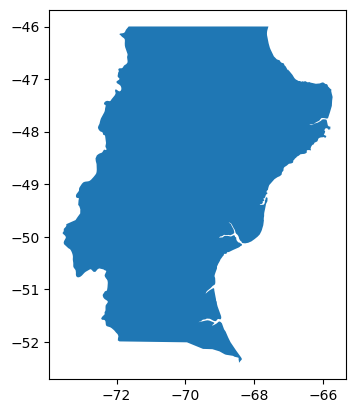

In [5]:
provinces = gpd.read_file("./data/states_provinces/ne_10m_admin_1_states_provinces.shp")
# Find Santa Cruz in the dataset
scdf = provinces.loc[(provinces['name'] == province) & (provinces['admin'] == country)]
scdf = scdf.reset_index(drop=True)
scdf.plot()

In [6]:
sc_shape = scdf.at[0,'geometry']

----

## Get NDVI Data

"The Terra Moderate Resolution Imaging Spectroradiometer (MODIS) Vegetation Indices Monthly (MOD13C2) Version 6.1 product provides a Vegetation Index (VI) value at a per pixel basis. There are two primary vegetation layers. The first is the Normalized Difference Vegetation Index (NDVI) which is referred to as the continuity index to the existing National Oceanic and Atmospheric Administration-Advanced Very High Resolution Radiometer (NOAA-AVHRR) derived NDVI. The second vegetation layer is the Enhanced Vegetation Index (EVI), which has improved sensitivity over high biomass regions.

The Climate Modeling Grid (CMG) consists of 3,600 rows and 7,200 columns of 5,600 meter (m) pixels. In generating this monthly product, the algorithm ingests all the MOD13A2 products that overlap the month and employs a weighted temporal average. Global MOD13C2 data are cloud-free spatial composites and are provided as a Level 3 product projected on a 0.05 degree (5,600 m) geographic CMG. The MOD13C2 has data fields for the NDVI, EVI, VI QA, reflectance data, angular information, and spatial statistics such as mean, standard deviation, and number of used input pixels at the 0.05 degree CMG resolution."

### Get from NASA EarthData

In [7]:
auth = earthaccess.login()

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/04/2023
Using environment variables for EDL


In [8]:
results = earthaccess.search_data(
    short_name='MOD13A3',
    cloud_hosted=True,
    bounding_box=(-70.64648,-67.51758, -47.16623,-50.38163),
    temporal=("2020-11-01", "2020-11-30"),
    count=2
)
results

Granules found: 3


[Collection: {'ShortName': 'MOD13A3', 'Version': '061'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -39.896145169414, 'Latitude': -60.0467641638326}, {'Longitude': -30.897106997634, 'Latitude': -49.7468157039077}, {'Longitude': -46.5118692387129, 'Latitude': -49.7270972103099}, {'Longitude': -60.0311585226916, 'Latitude': -59.9975304281197}, {'Longitude': -39.896145169414, 'Latitude': -60.0467641638326}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-11-01T00:00:00.000Z', 'EndingDateTime': '2020-11-30T23:59:59.000Z'}}
 Size(MB): 1.32924
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD13A3.061/MOD13A3.A2020306.h15v14.061.2020357083916/MOD13A3.A2020306.h15v14.061.2020357083916.hdf'],
 Collection: {'ShortName': 'MOD13A3', 'Version': '061'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -59.9718052248657,

In [9]:
# Download file to local
if not os.path.exists('data/ndvi/1km/raw'):
  files = earthaccess.download(results, "./data/ndvi/1km/raw")

In [10]:
files = os.listdir('data/ndvi/1km/raw')

Merging two datasets together to get full coverage of the province

In [11]:
datasets = []
for file in files:
    datasets.append(rxr.open_rasterio('data/ndvi/1km/raw/{}'.format(file), masked=True))

modis = xr.merge(datasets)
modis

<xarray.Dataset>
Dimensions:                              (band: 1, x: 1200, y: 2400)
Coordinates:
  * band                                 (band) int64 1
  * x                                    (x) float64 -5.559e+06 ... -4.448e+06
  * y                                    (y) float64 -6.671e+06 ... -4.448e+06
    spatial_ref                          int64 0
Data variables:
    1 km monthly NDVI                    (band, y, x) float32 nan nan ... nan
    1 km monthly relative azimuth angle  (band, y, x) float32 nan nan ... nan
    1 km monthly pixel reliability       (band, y, x) float32 nan nan ... nan
    1 km monthly EVI                     (band, y, x) float32 nan nan ... nan
    1 km monthly VI Quality              (band, y, x) float32 nan nan ... nan
    1 km monthly red reflectance         (band, y, x) float32 nan nan ... nan
    1 km monthly NIR reflectance         (band, y, x) float32 nan nan ... nan
    1 km monthly blue reflectance        (band, y, x) float32 nan nan ... nan
    1 km monthly MIR reflectance         (band, y, x) float32 nan nan ... nan
    1 km monthly view zenith angle       (band, y, x) float32 nan nan ... nan
    1 km monthly sun zenith angle        (band, y, x) float32 nan nan ... nan
Attributes: (12/165)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A3
    ALGORITHMPACKAGEVERSION:             5
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             -59.9999999946118
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51013014
    VERSIONID:                           61
    VERTICALTILENUMBER:                  14
    WESTBOUNDINGCOORDINATE:              -99.9999999747313

### Select desired band (NDVI)

In [12]:
ndvi = modis['1 km monthly NDVI']
ndvi

<xarray.DataArray '1 km monthly NDVI' (band: 1, y: 2400, x: 1200)>
array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [1939., 1794., 1882., ...,   nan,   nan,   nan],
        [1807., 1931., 1888., ...,   nan,   nan,   nan],
        [2083., 2117., 2017., ...,   nan,   nan,   nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.559e+06 -5.558e+06 ... -4.449e+06 -4.448e+06
  * y            (y) float64 -6.671e+06 -6.67e+06 ... -4.449e+06 -4.448e+06
    spatial_ref  int64 0
Attributes:
    add_offset:        0.0
    add_offset_err:    0
    calibrated_nt:     5
    long_name:         1 km monthly NDVI
    scale_factor:      10000.0
    scale_factor_err:  0
    units:             NDVI
    valid_range:       -2000, 10000

### Clip to just Santa Cruz area

In [13]:
modis_clip = ndvi.rio.clip(scdf.geometry.apply(mapping), scdf.crs, drop=False, invert=False)
modis_clip

<xarray.DataArray '1 km monthly NDVI' (band: 1, y: 2400, x: 1200)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.559e+06 -5.558e+06 ... -4.449e+06 -4.448e+06
  * y            (y) float64 -6.671e+06 -6.67e+06 ... -4.449e+06 -4.448e+06
    spatial_ref  int64 0
Attributes:
    add_offset:        0.0
    add_offset_err:    0
    calibrated_nt:     5
    long_name:         1 km monthly NDVI
    scale_factor:      10000.0
    scale_factor_err:  0
    units:             NDVI
    valid_range:       -2000, 10000

In [14]:
# For mapping
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces',
        scale='10m',
        facecolor='none')
bounds = [-77.09276372561895,-63.54029983538979,-44.44687551389838,-53.59545491495126]

### Plot NVDI

Because we are still working in the Sinusoidal projection, the map will look warped at this stage. We will reproject it at the end

Text(0.5, 1.0, 'Barren area in Santa Cruz province')

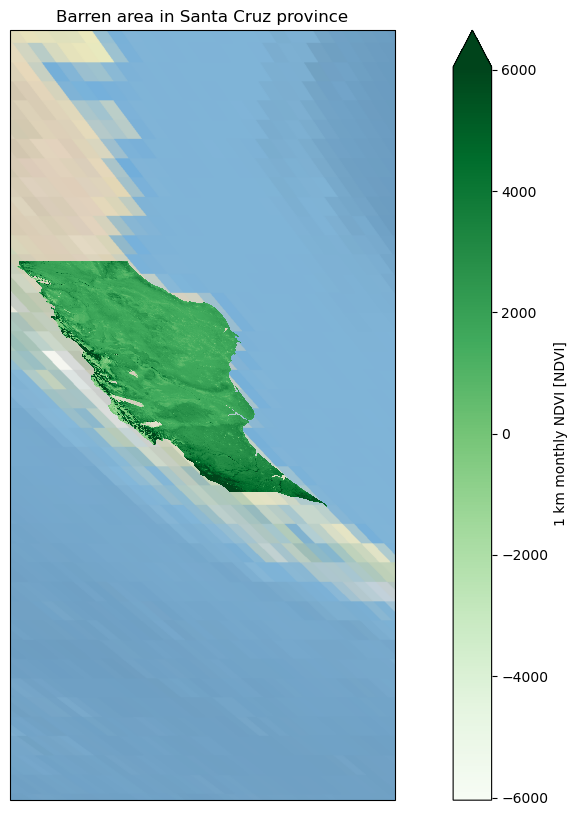

In [15]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(projection=ccrs.Sinusoidal())
modis_clip.plot(ax=ax, robust=True,cmap='Greens')
ax.stock_img()
plt.title('Barren area in Santa Cruz province')

(array([  1953.,   5438.,  68495., 144882.,  35068.,  13444.,   5987.,
          2795.,   1193.,    207.]),
 array([-2000.,  -800.,   400.,  1600.,  2800.,  4000.,  5200.,  6400.,
         7600.,  8800., 10000.]),
 <BarContainer object of 10 artists>)

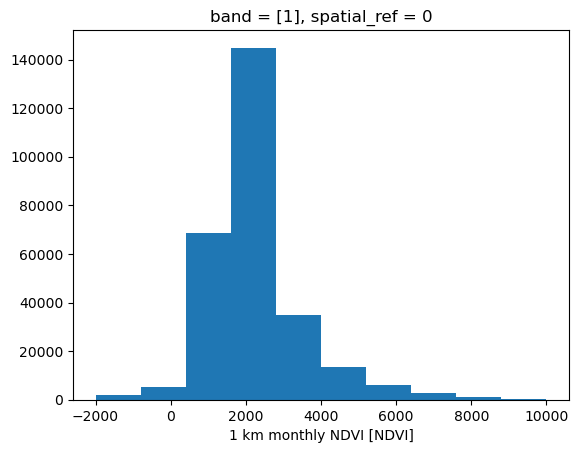

In [16]:
modis_clip.plot.hist()

----

The values from MODIS range from -2000 to 10000.

"NDVI values range from +1.0 to -1.0. Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5). High NDVI values (approximately 0.6 to 0.9) correspond to dense vegetation such as that found in temperate and tropical forests or crops at their peak growth stage."

So the data needs to be normalized to that scale.

### Normalize range (-1 to 1)

In [17]:
normalized_data = (modis_clip - modis_clip.min()) / (modis_clip.max() - modis_clip.min())  # Normalize to 0 to 1 range
normalized_data = (normalized_data * 2) - 1  # Normalize to -1 to 1 range

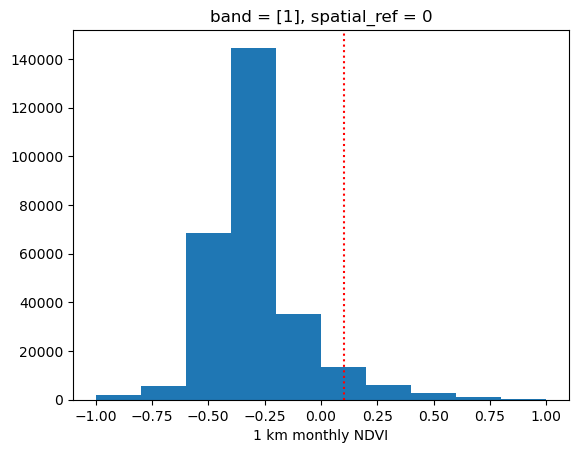

In [18]:
normalized_data.plot.hist()
plt.axvline(x=0.1, color='red', linestyle='dotted')

We can see already that the majority of land in the province is barren

### Clip to barren area (NDVI <= 0.1)

In [19]:
barren_area = normalized_data.where(normalized_data <= 0.1)

## Calculate Barren Area

In [20]:
# Get total area for the province
modis_clip.notnull().sum()

<xarray.DataArray '1 km monthly NDVI' ()>
array(279462)
Coordinates:
    spatial_ref  int64 0

In [21]:
# Get barren area
barren_area.notnull().sum()

<xarray.DataArray '1 km monthly NDVI' ()>
array(264578)
Coordinates:
    spatial_ref  int64 0

## Santa Cruz, Argentina has 264,578 km2 of barren (NDVI <= 0.1) land

----

## Mapping Barren Land

In [22]:
normalized_data.rio.to_raster('./data/ndvi/1km/normalized_data.tif')

In [23]:
out_path = './data/ndvi/1km/normalized_data.tif'
# Set desitnation CRS
# 
dst_crs = rasterio.crs.CRS.from_epsg(4326)

# set out path
out_path_rproj = out_path.replace('.tif','-warped.tif')

with rasterio.open(out_path) as src:
    # get src bounds and transform
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
    # reproject and write to file
    with rasterio.open(out_path_rproj, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rasterio.band(src, i),
                      destination=rasterio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)

In [24]:
normalized_geowarped = rxr.open_rasterio('./data/ndvi/1km/normalized_data-warped.tif')

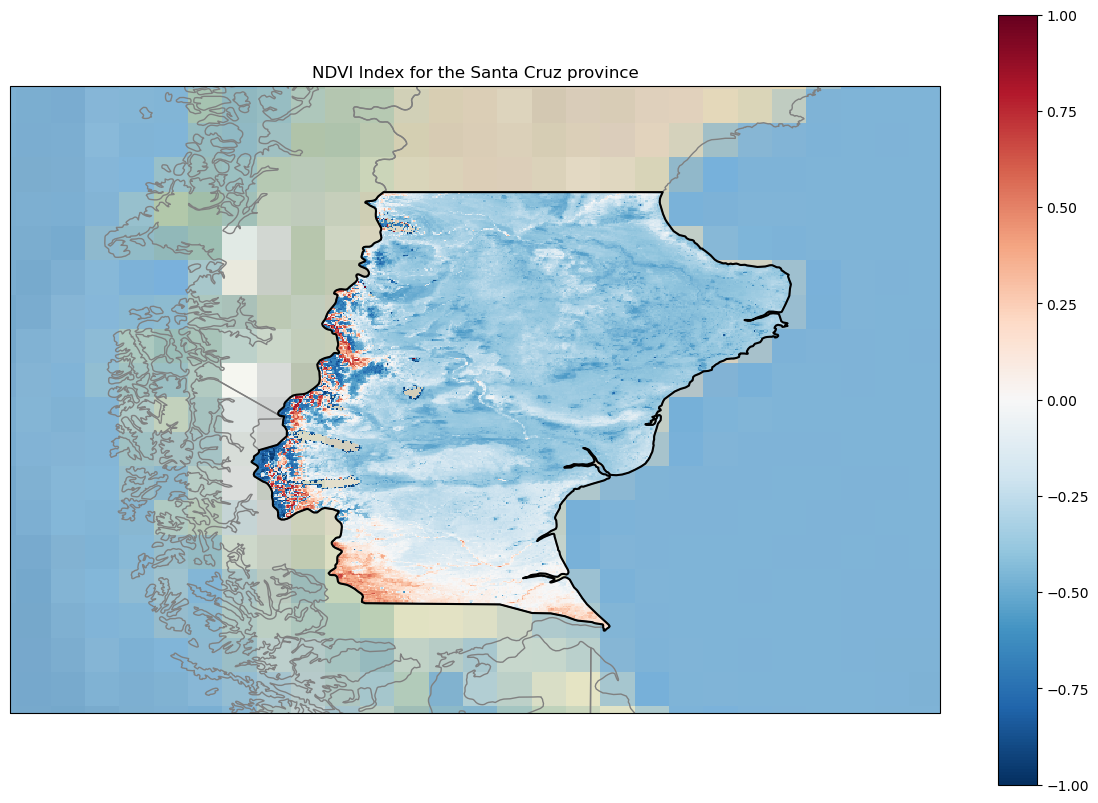

In [26]:
clipped = normalized_geowarped.rio.clip(scdf.geometry.apply(mapping), scdf.crs, drop=False, invert=False)
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
clipped.plot(ax=ax)

scdf.boundary.plot(ax=ax,color='black')
plt.title('NDVI Index for the Santa Cruz province')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()